In [ ]:
! pip install facenet-pytorch

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import torchvision.models as models
import copy
import zipfile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/data/


/content/drive/MyDrive/data


In [ ]:
%ls

affectNet.zip                       generated_angry_faces.png
cvae_emotion_face_model.pth         generated_happy_faces.png
data_for_zip.zip                    loss_curves.png
face_reconstruction_generation.png


In [ ]:
import zipfile
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image

# Extract both datasets
zip_paths = [
    "/content/drive/MyDrive/data/data_for_zip.zip",
    "/content/drive/MyDrive/data/affectNet.zip"
]
extract_paths = [
    "/content/dataset1",
    "/content/dataset2"
]

In [ ]:
for zip_path, extract_path in zip(zip_paths, extract_paths):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: /content/dataset1
Dataset extracted to: /content/dataset2


In [ ]:
import os
print("Top-level files and folders:")
print(os.listdir('/content/dataset2/'))
print(os.listdir('/content/dataset1/'))

Top-level files and folders:
['YOLO_format']
['data_for_zip']


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
data_dir = "/content/dataset2/YOLO_format/"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Define constants
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 128
FACENET_EMBEDDING_DIM = 512
LEARNING_RATE = 1e-4
NUM_CONDITIONS = 2  # Only happy and angry

# Emotion mapping - we're only using Anger (0) and Happy (4)
emotion_class_map = {
    0: 'Anger',  # Original class ID 0
    1: 'Happy'   # Original class ID 4 mapped to 1 for our binary classification
}

# Which original classes to keep (Anger=0, Happy=4)
keep_classes = [0, 4]

# Custom dataset2 class for loading the face images with emotion labels
class FaceEmotionDataset2(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get all image files
        images_dir = os.path.join(root_dir, "images")
        labels_dir = os.path.join(root_dir, "labels")
        count=0
        for img_name in os.listdir(images_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                # Get corresponding label file
                base_name = os.path.splitext(img_name)[0]
                label_file = os.path.join(labels_dir, f"{base_name}.txt")

                # Only include images that have corresponding label files
                if os.path.exists(label_file):
                    # Read label to check if it's Happy or Angry
                    with open(label_file, 'r') as f:
                        label_line = f.readline().strip().split()
                        original_class_id = int(label_line[0])

                        # Only keep Happy (4) and Angry (0) classes
                        if original_class_id in keep_classes:
                            count+=1
                            # Map the original class IDs to our binary labels:
                            # 0 (Anger) stays as 0
                            # 4 (Happy) becomes 1
                            new_class_id = 0 if original_class_id == 0 else 1

                            self.image_paths.append(os.path.join(images_dir, img_name))
                            self.labels.append(new_class_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        class_id = self.labels[idx]

        # Read image
        image = Image.open(img_path).convert('L')  # Use RGB instead of grayscale

        # Convert label to one-hot encoding
        label_one_hot = torch.zeros(NUM_CONDITIONS)
        label_one_hot[class_id] = 1.0

        if self.transform:
            image = self.transform(image)
        return image, label_one_hot, class_id  # Return image, one-hot encoded label, and class index

vgg_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Create dataset2s and dataloaders
train_dataset2 = FaceEmotionDataset2(train_dir, transform=vgg_transform)
valid_dataset2 = FaceEmotionDataset2(valid_dir, transform=vgg_transform)
test_dataset2 = FaceEmotionDataset2(test_dir, transform=vgg_transform)

# Print dataset2 info
print(f"Training images: {len(train_dataset2)}")
print(f"Training images: {len(valid_dataset2)}")
print(f"Testing images: {len(test_dataset2)}")

Using device: cuda
Training images: 4493
Training images: 1503
Testing images: 782


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/data/data_for_zip.zip"
extract_path = "/content/dataset1"  # local Colab storage

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset1 extracted to:", extract_path)

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
data_dir = "/content/dataset1/data_for_zip/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define constants
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 128
FACENET_EMBEDDING_DIM = 512
LEARNING_RATE = 1e-4
NUM_CONDITIONS = 2  # happy and angry

# Custom dataset1 class for loading the black and white face images
class FaceEmotionDataset1(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Get labels from directory structure
        # 0 for angry, 1 for happy
        for label_id, emotion in enumerate(["angry", "happy"]):
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.exists(emotion_dir):
                for img_name in os.listdir(emotion_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(emotion_dir, img_name))
                        self.labels.append(label_id)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        # Convert label to one-hot encoding
        label_one_hot = torch.zeros(NUM_CONDITIONS)
        label_one_hot[label] = 1.0

        if self.transform:
            image = self.transform(image)

        return image, label_one_hot, label  # Return image, one-hot encoded label, and class index

# FaceNet requires input size of 160x160
vgg_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Create dataset1s and dataloaders
train_dataset1 = FaceEmotionDataset1(train_dir, transform=vgg_transform)
test_dataset1 = FaceEmotionDataset1(test_dir, transform=vgg_transform)

train_dataset1_shuffled = copy.deepcopy(train_dataset1)
indices = torch.randperm(len(train_dataset1)).tolist()
train_dataset1_shuffled.image_paths = [train_dataset1.image_paths[i] for i in indices]
train_dataset1_shuffled.labels = [train_dataset1.labels[i] for i in indices]

# Print dataset info
print(f"Training images: {len(train_dataset1)}")
print(f"Shuffled training images: {len(train_dataset1_shuffled)}")
print(f"Testing images: {len(test_dataset1)}")

# Print dataset1 info
print(f"Training images: {len(train_dataset1)}")
print(f"Testing images: {len(test_dataset1)}")



Dataset1 extracted to: /content/dataset1
Using device: cuda
Training images: 12794
Shuffled training images: 12794
Testing images: 2843
Training images: 12794
Testing images: 2843


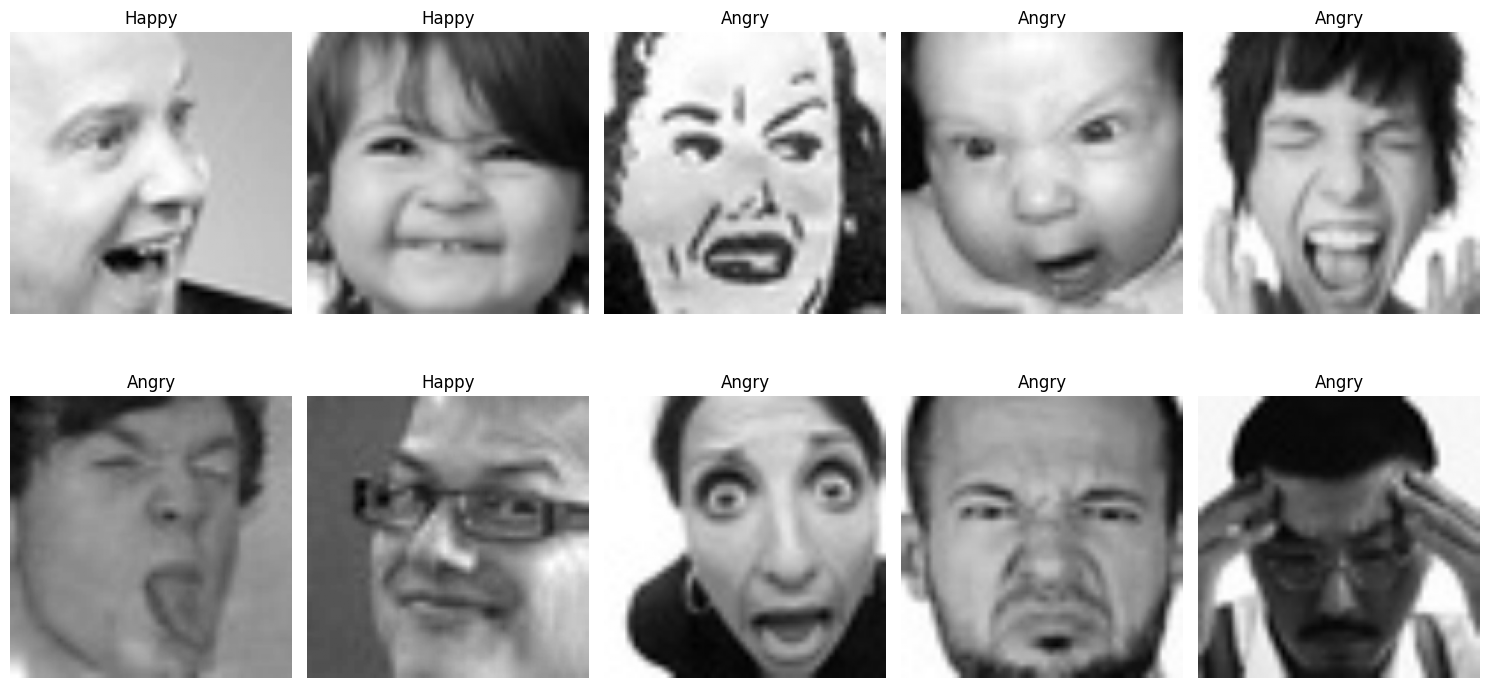

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set the figure size
plt.figure(figsize=(15, 8))

# Choose 10 random indices
random_indices = random.sample(range(len(train_dataset1)), 10)

# Map numeric labels to emotion names
emotion_map = {0: "Angry", 1: "Happy"}

# Plot each image
for i, idx in enumerate(random_indices):
    image, _, label = train_dataset1[idx]  # Get image and class index
    # Convert from tensor to numpy array
    # Denormalize: (img * std) + mean
    image_np = (image.numpy()[0] * 0.5 + 0.5)  # Convert from [-1,1] to [0,1]

    # Create subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f"{emotion_map[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import ConcatDataset

# Merge training datasets (train_dataset1, train_dataset2, valid_dataset2)
train_dataset = ConcatDataset([train_dataset1, train_dataset2, valid_dataset2])

# Merge test datasets (test_dataset1, test_dataset2)
test_dataset = ConcatDataset([test_dataset1, test_dataset2])

# Create data loaders for the merged datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print information about the merged datasets
print(f"Combined training dataset size: {len(train_dataset)} images")
print(f"Combined test dataset size: {len(test_dataset)} images")

# Calculate class distribution in the merged training dataset
class_counts_train = [0, 0]  # For Angry (0) and Happy (1)

# Count classes in train_dataset1
for _, _, label in train_dataset1:
    class_counts_train[label] += 1

# Count classes in train_dataset2
for _, _, label in train_dataset2:
    class_counts_train[label] += 1

# Count classes in valid_dataset2
for _, _, label in valid_dataset2:
    class_counts_train[label] += 1

# Print class distribution for the combined training dataset
print("\nClass distribution in combined training dataset:")
print(f"Angry: {class_counts_train[0]} images ({class_counts_train[0]/len(train_dataset)*100:.2f}%)")
print(f"Happy: {class_counts_train[1]} images ({class_counts_train[1]/len(train_dataset)*100:.2f}%)")

Combined training dataset size: 18790 images
Combined test dataset size: 3625 images

Class distribution in combined training dataset:
Angry: 8630 images (45.93%)
Happy: 10160 images (54.07%)


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import random

def visualize_batch(dataloader, title="Batch Samples"):
    """
    Visualize a batch of samples from the dataloader
    """
    # Get a batch
    images, conditions, labels = next(iter(dataloader))

    # Select 10 images (or fewer if batch size is smaller)
    num_samples = min(10, images.size(0))

    # Set up the figure
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        # Convert tensor to numpy for plotting
        img_np = images[i].numpy().squeeze()

        # Denormalize
        img_np = img_np * 0.5 + 0.5

        # Get emotion label
        emotion = "Happy" if labels[i] == 1 else "Angry"

        # Plot
        axes[i].imshow(img_np)
        axes[i].set_title(f"{emotion}")
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize a batch (alternative approach)
print("Visualizing samples from a batch...")
visualize_batch(train_loader, title="Training Batch Samples")

Visualizing samples from a batch...


NameError: name 'train_loader' is not defined

In [ ]:
# Load and freeze VGG19 model
class VGGFeatureExtractor(nn.Module):
    def __init__(self, unfreeze_top_n_layers=3):
        super(VGGFeatureExtractor, self).__init__()

        # Load pretrained VGG19 model
        vgg19 = models.vgg19(pretrained=True)

        # Remove the classifier (fully connected layers)
        self.features = vgg19.features

        # Define a new classifier to get embeddings
        self.feature_size = self._get_feature_size((1, 3, 160, 160))

        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512)  # Output embedding dimension
        )
        """
        Creates a dummy input tensor with dimensions (1, 3, 160, 160), representing:

        Batch size of 1
        3 color channels (RGB)
        Height and width of 160x160 pixels


        Passes this dummy input through the VGG convolutional layers
        Calculates the total number of features per sample by dividing the total elements by the batch size

        This is necessary because when you remove the original classifier, you need to know exactly how many features the convolutional layers produce to properly connect your new classifier's input layer.
        """

        # Step 1: Freeze all layers first
        for param in self.features.parameters():
            param.requires_grad = False

        # Step 2: Unfreeze last `n` layers
        if unfreeze_top_n_layers > 0:
            print(f"Unfreezing top {unfreeze_top_n_layers} layers...")
            layers = list(self.features.named_children())
            for name, module in layers[-unfreeze_top_n_layers:]:
                print(f"Unfreezing: {name}")
                for param in module.parameters():
                    param.requires_grad = True

        # Always train the classifier
        for param in self.classifier.parameters():
            param.requires_grad = True

    def _get_feature_size(self, input_size):
        # Helper function to calculate output feature dimensions
        dummy_input = torch.zeros(input_size)
        with torch.no_grad():
            output = self.features(dummy_input)
        return output.numel() // output.shape[0]

    def forward(self, x):
        # Ensure input is 3-channel (RGB)
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)

        # Extract features with VGG19
        x = self.features(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Get embeddings
        embeddings = self.classifier(x)

        return embeddings

# Define the Encoder part of the CVAE
class Encoder(nn.Module):
    def __init__(self, vgg_dim=512, condition_dim=NUM_CONDITIONS, latent_dim=LATENT_DIM):
        super(Encoder, self).__init__()

        combined_input_dim = vgg_dim + condition_dim

        self.fc1 = nn.Linear(combined_input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

    def forward(self, face_features, condition):
        # Concatenate face features and condition
        x = torch.cat([face_features, condition], dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

# Modified Decoder without inception blocks, more symmetric to VGG
class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, condition_dim=NUM_CONDITIONS):
        super(Decoder, self).__init__()
        self.combined_input_dim = latent_dim + condition_dim

        # Initial projection from latent space to 10x10
        self.fc = nn.Linear(self.combined_input_dim, 256 * 10 * 10)
        self.bn_init = nn.BatchNorm2d(256)

        # Simpler upsampling blocks
        # Block 1: 10x10 -> 20x20
        self.tconv1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(256)

        # Block 2: 20x20 -> 40x40
        self.tconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Block 3: 40x40 -> 80x80
        self.tconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Block 4: 80x80 -> 160x160
        self.tconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        # Final output layer
        self.conv_out = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, z, condition):
        # Concatenate latent vector with condition
        x = torch.cat([z, condition], dim=1)

        # Initial projection and reshaping
        x = self.fc(x)
        x = x.view(-1, 256, 10, 10)  # Reshape to larger initial feature map
        x = F.relu(self.bn_init(x))

        # Simplified upsampling blocks
        x = F.relu(self.bn1(self.tconv1(x)))  # 10x10 -> 20x20
        x = F.relu(self.bn2(self.tconv2(x)))  # 20x20 -> 40x40
        x = F.relu(self.bn3(self.tconv3(x)))  # 40x40 -> 80x80
        x = F.relu(self.bn4(self.tconv4(x)))  # 80x80 -> 160x160

        # Final output
        x = torch.sigmoid(self.conv_out(x))

        return x

# Define the full CVAE model
class ConditionalVAE(nn.Module):
    def __init__(self, feature_extractor, latent_dim=LATENT_DIM, condition_dim=NUM_CONDITIONS):
        super(ConditionalVAE, self).__init__()

        self.feature_extractor = feature_extractor
        self.encoder = Encoder(512, condition_dim, latent_dim)  # VGG embedding dimension is 512
        self.decoder = Decoder(latent_dim, condition_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x, condition):
        # Extract features using VGG19
        face_features = self.feature_extractor(x)

        # Encode the features with condition to get latent distribution
        mu, logvar = self.encoder(face_features, condition)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode the latent vector with condition to reconstruct the image
        reconstructed = self.decoder(z, condition)

        return reconstructed, mu, logvar

    def generate(self, condition, num_samples=1):
        # Generate random latent vectors
        z = torch.randn(num_samples, LATENT_DIM).to(device)

        # Ensure condition is properly formatted - expand to match batch size
        if condition.size(0) == 1 and num_samples > 1:
            condition = condition.expand(num_samples, -1)  # Repeat the condition for each sample

        # Generate images from latent vectors and condition
        with torch.no_grad():
            generated = self.decoder(z, condition)

        return generated

# Instantiate the models
vgg_extractor = VGGFeatureExtractor(unfreeze_top_n_layers=1).to(device)
cvae = ConditionalVAE(vgg_extractor).to(device)

# Set up the optimizer
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

def get_beta(epoch, total_epochs, max_beta=0.1):
    """Linear annealing from 0 to max_beta over total_epochs"""
    return max_beta * (epoch / total_epochs)

# Define the loss function
def loss_function(recon_x, x, mu, logvar, kld_weight=0.01):
    # For BCE loss, scale images from [-1, 1] to [0, 1]
    x_scaled = (x + 1) / 2
    recon_x_scaled = (recon_x + 1) / 2
    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x_scaled, x_scaled, reduction='sum')

    # KL Divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kld_weight * kld_loss, recon_loss, kld_loss

NameError: name 'nn' is not defined

In [ ]:
def get_beta(epoch, total_epochs, max_beta=0.3):
    """Linear beta annealing from 0 to max_beta"""
    return max_beta * (epoch / total_epochs)

# Training function
def train(model, dataloader, optimizer, epoch):
    model.train()
    train_loss = 0

    beta = get_beta(epoch, EPOCHS, max_beta=0.1)

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} (β={beta:.4f})")

    for batch_idx, (data, condition, _) in enumerate(progress_bar):
        data, condition = data.to(device), condition.to(device)

        optimizer.zero_grad()

        # Forward pass
        recon_data, mu, logvar = model(data, condition)

        # Calculate loss with current beta
        loss, recon_loss, kl_loss = loss_function(recon_data, data, mu, logvar, kld_weight=beta)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix({
            "Loss": loss.item() / len(data),
            "Recon": recon_loss.item() / len(data),
            "KL": kl_loss.item() / len(data),
            "β": beta
        })

    avg_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}, Avg Train Loss: {avg_loss:.4f}, β: {beta:.4f}")
    return avg_loss

# Testing function
def test(model, dataloader, epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (data, condition, _) in enumerate(dataloader):
            data, condition = data.to(device), condition.to(device)

            # Forward pass
            recon_data, mu, logvar = model(data, condition)

            # Calculate loss
            loss, _, _ = loss_function(recon_data, data, mu, logvar)

            test_loss += loss.item()

    avg_loss = test_loss / len(dataloader.dataset)
    print(f"Epoch: {epoch+1}, Average Test Loss: {avg_loss:.4f}")
    return avg_loss

# Function to visualize original and reconstructed images
def visualize_results(model, dataloader, num_samples=5):
    model.eval()

    angry_condition = torch.zeros(1, NUM_CONDITIONS).to(device)
    angry_condition[0, 0] = 1  # angry

    happy_condition = torch.zeros(1, NUM_CONDITIONS).to(device)
    happy_condition[0, 1] = 1  # Happy

    plt.figure(figsize=(12, 6))

    # Get a batch of data
    data, conditions, labels = next(iter(dataloader))
    data = data.to(device)
    conditions = conditions.to(device)

    # Reconstruct original images
    with torch.no_grad():
        recon_batch, _, _ = model(data[:num_samples], conditions[:num_samples])

        # Generate new faces with specified emotions
        generated_angry = model.generate(angry_condition, num_samples)
        generated_happy = model.generate(happy_condition, num_samples)

    # Plot original images
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1)
        plt.imshow(data[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Plot reconstructed images
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1 + num_samples)
        plt.imshow(recon_batch[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    # Plot generated angry faces
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1 + 2*num_samples)
        plt.imshow(generated_angry[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Generated (angry)")
        plt.axis('off')

    # Plot generated happy faces
    for i in range(num_samples):
        ax = plt.subplot(4, num_samples, i + 1 + 3*num_samples)
        plt.imshow(generated_happy[i].cpu().squeeze().numpy(), cmap='gray')
        plt.title("Generated (Happy)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('face_reconstruction_generation.png')
    plt.show()

In [ ]:
def main():
    # Instantiate the models
    vgg_extractor = VGGFeatureExtractor(unfreeze_top_n_layers=1).to(device)
    cvae = ConditionalVAE(vgg_extractor).to(device)

    # Set up the optimizer - use separate optimizers with different learning rates
    decoder_params = list(cvae.decoder.parameters())
    other_params = list(cvae.encoder.parameters()) + list(cvae.feature_extractor.parameters())

    optimizer = optim.Adam([
        {'params': decoder_params, 'lr': LEARNING_RATE * 1.5},  # Higher learning rate for decoder
        {'params': other_params, 'lr': LEARNING_RATE}
    ])

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Initialize loss tracking
    train_losses = []
    test_losses = []
    train_face_confs = []
    test_face_confs = []

    # Track each loss component separately
    train_recon_losses = []
    train_kld_losses = []
    train_face_losses = []
    test_recon_losses = []
    test_kld_losses = []
    test_face_losses = []

    for epoch in range(EPOCHS):
        # Training
        train_loss, train_recon, train_kld, train_face, train_face_conf = train(
            cvae, train_loader, optimizer, epoch, EPOCHS
        )

        # Testing
        test_loss, test_recon, test_kld, test_face, test_face_conf = test(
            cvae, test_loader, epoch, EPOCHS
        )

        # Update learning rate based on validation loss
        scheduler.step(test_loss)

        # Store losses and metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_face_confs.append(train_face_conf)
        test_face_confs.append(test_face_conf)

        train_recon_losses.append(train_recon)
        train_kld_losses.append(train_kld)
        train_face_losses.append(train_face)
        test_recon_losses.append(test_recon)
        test_kld_losses.append(test_kld)
        test_face_losses.append(test_face)

        # Save model checkpoint
        if (epoch + 1) % 5 == 0 or epoch == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': cvae.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'test_loss': test_loss,
            }, f'cvae_checkpoint_epoch_{epoch+1}.pth')

        # Visualize results every few epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            visualize_results(cvae, test_loader, epoch)

    # Save the final trained model
    torch.save(cvae.state_dict(), 'cvae_emotion_face_model_final.pth')

    # Plot loss curves
    plt.figure(figsize=(15, 10))

    # Plot total losses
    plt.subplot(2, 2, 1)
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    # Plot face detection confidence
    plt.subplot(2, 2, 2)
    plt.plot(range(1, EPOCHS + 1), train_face_confs, label='Train Face Confidence')
    plt.plot(range(1, EPOCHS + 1), test_face_confs, label='Test Face Confidence')
    plt.xlabel('Epoch')
    plt.ylabel('Face Detection Confidence')
    plt.title('Face Detection Confidence')
    plt.legend()

    # Plot individual loss components - training
    plt.subplot(2, 2, 3)
    plt.plot(range(1, EPOCHS + 1), train_recon_losses, label='Reconstruction Loss')
    plt.plot(range(1, EPOCHS + 1), train_kld_losses, label='KL Divergence Loss')
    plt.plot(range(1, EPOCHS + 1), train_face_losses, label='Face Detection Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Component')
    plt.title('Training Loss Components')
    plt.legend()

    # Plot individual loss components - testing
    plt.subplot(2, 2, 4)
    plt.plot(range(1, EPOCHS + 1), test_recon_losses, label='Reconstruction Loss')
    plt.plot(range(1, EPOCHS + 1), test_kld_losses, label='KL Divergence Loss')
    plt.plot(range(1, EPOCHS + 1), test_face_losses, label='Face Detection Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Component')
    plt.title('Testing Loss Components')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()

    # Generate final sample faces
    print("Generating final sample faces...")
    happy_faces, happy_confs = generate_faces(cvae, "happy", 10, 'final_happy_faces.png')
    angry_faces, angry_confs = generate_faces(cvae, "angry", 10, 'final_angry_faces.png')

    # Print final face detection stats
    print(f"Happy faces - Avg confidence: {sum(happy_confs)/len(happy_confs):.4f}")
    print(f"Angry faces - Avg confidence: {sum(angry_confs)/len(angry_confs):.4f}")

Epoch 1/30 (β=0.0000): 100%|██████████| 294/294 [01:53<00:00,  2.60it/s, Loss=1.78e+4, Recon=1.78e+4, KL=3.23e+4, β=0]


Epoch 1, Avg Train Loss: 18384.8364, β: 0.0000
Epoch: 1, Average Test Loss: 17831.3257


Epoch 2/30 (β=0.0033): 100%|██████████| 294/294 [01:55<00:00,  2.54it/s, Loss=1.73e+4, Recon=1.73e+4, KL=894, β=0.00333]


Epoch 2, Avg Train Loss: 17494.8719, β: 0.0033
Epoch: 2, Average Test Loss: 17383.1227


Epoch 3/30 (β=0.0067): 100%|██████████| 294/294 [01:55<00:00,  2.54it/s, Loss=1.73e+4, Recon=1.72e+4, KL=547, β=0.00667]


Epoch 3, Avg Train Loss: 17344.4688, β: 0.0067
Epoch: 3, Average Test Loss: 17316.3722


Epoch 4/30 (β=0.0100): 100%|██████████| 294/294 [01:55<00:00,  2.54it/s, Loss=1.75e+4, Recon=1.75e+4, KL=532, β=0.01]


Epoch 4, Avg Train Loss: 17281.3176, β: 0.0100
Epoch: 4, Average Test Loss: 17267.7289


Epoch 5/30 (β=0.0133): 100%|██████████| 294/294 [01:55<00:00,  2.54it/s, Loss=1.73e+4, Recon=1.73e+4, KL=360, β=0.0133]


Epoch 5, Avg Train Loss: 17229.6054, β: 0.0133
Epoch: 5, Average Test Loss: 17239.6697


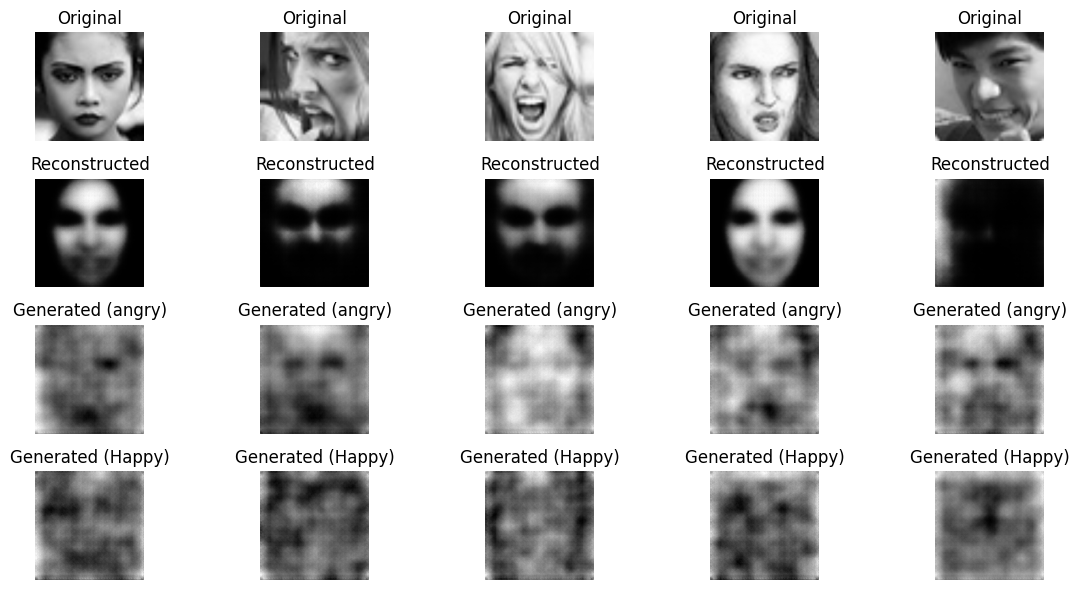

Epoch 6/30 (β=0.0167): 100%|██████████| 294/294 [01:56<00:00,  2.52it/s, Loss=1.71e+4, Recon=1.71e+4, KL=390, β=0.0167]


Epoch 6, Avg Train Loss: 17160.9404, β: 0.0167
Epoch: 6, Average Test Loss: 17155.4877


Epoch 7/30 (β=0.0200): 100%|██████████| 294/294 [01:56<00:00,  2.52it/s, Loss=1.69e+4, Recon=1.69e+4, KL=321, β=0.02]


Epoch 7, Avg Train Loss: 17076.6937, β: 0.0200
Epoch: 7, Average Test Loss: 17121.9594


Epoch 8/30 (β=0.0233): 100%|██████████| 294/294 [01:56<00:00,  2.52it/s, Loss=1.71e+4, Recon=1.71e+4, KL=325, β=0.0233]


Epoch 8, Avg Train Loss: 17023.4674, β: 0.0233
Epoch: 8, Average Test Loss: 17073.5713


Epoch 9/30 (β=0.0267): 100%|██████████| 294/294 [01:56<00:00,  2.51it/s, Loss=1.65e+4, Recon=1.64e+4, KL=276, β=0.0267]


Epoch 9, Avg Train Loss: 16975.2971, β: 0.0267
Epoch: 9, Average Test Loss: 17056.7392


Epoch 10/30 (β=0.0300): 100%|██████████| 294/294 [01:56<00:00,  2.52it/s, Loss=1.71e+4, Recon=1.71e+4, KL=254, β=0.03]


Epoch 10, Avg Train Loss: 16943.5971, β: 0.0300
Epoch: 10, Average Test Loss: 17043.0970


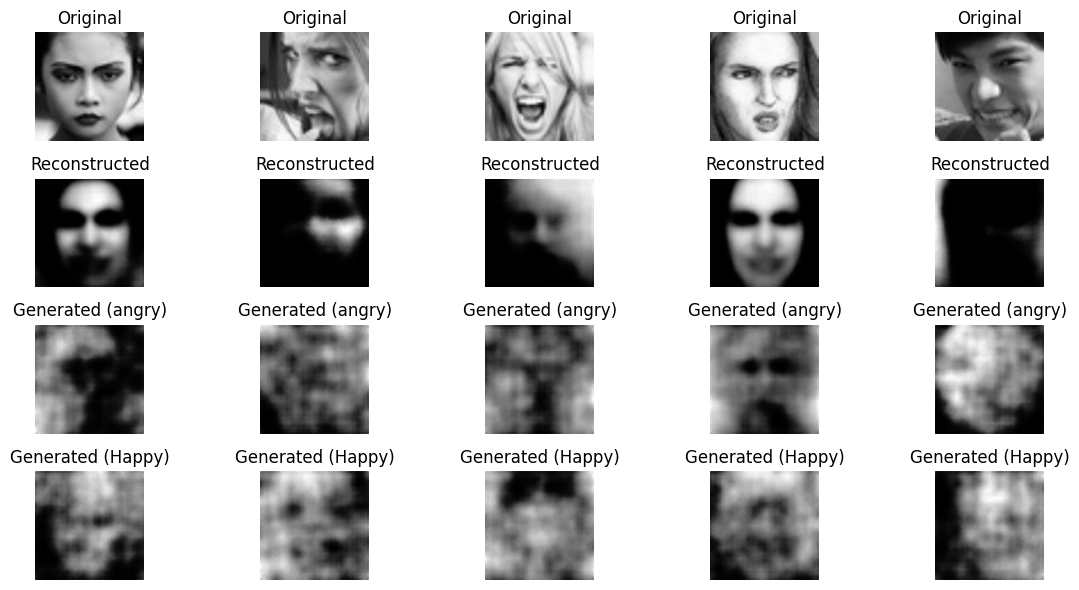

Epoch 11/30 (β=0.0333): 100%|██████████| 294/294 [01:57<00:00,  2.50it/s, Loss=1.69e+4, Recon=1.69e+4, KL=261, β=0.0333]


Epoch 11, Avg Train Loss: 16915.0935, β: 0.0333
Epoch: 11, Average Test Loss: 17018.4217


Epoch 12/30 (β=0.0367): 100%|██████████| 294/294 [01:57<00:00,  2.50it/s, Loss=1.7e+4, Recon=1.7e+4, KL=249, β=0.0367]


Epoch 12, Avg Train Loss: 16889.3283, β: 0.0367
Epoch: 12, Average Test Loss: 17011.6713


Epoch 13/30 (β=0.0400): 100%|██████████| 294/294 [01:57<00:00,  2.50it/s, Loss=1.65e+4, Recon=1.64e+4, KL=214, β=0.04]


Epoch 13, Avg Train Loss: 16868.6581, β: 0.0400
Epoch: 13, Average Test Loss: 16994.1133


Epoch 14/30 (β=0.0433): 100%|██████████| 294/294 [01:57<00:00,  2.50it/s, Loss=1.68e+4, Recon=1.68e+4, KL=230, β=0.0433]


Epoch 14, Avg Train Loss: 16848.0799, β: 0.0433
Epoch: 14, Average Test Loss: 16982.9417


Epoch 15/30 (β=0.0467): 100%|██████████| 294/294 [01:57<00:00,  2.50it/s, Loss=1.7e+4, Recon=1.69e+4, KL=244, β=0.0467]


Epoch 15, Avg Train Loss: 16832.2548, β: 0.0467
Epoch: 15, Average Test Loss: 16984.7921


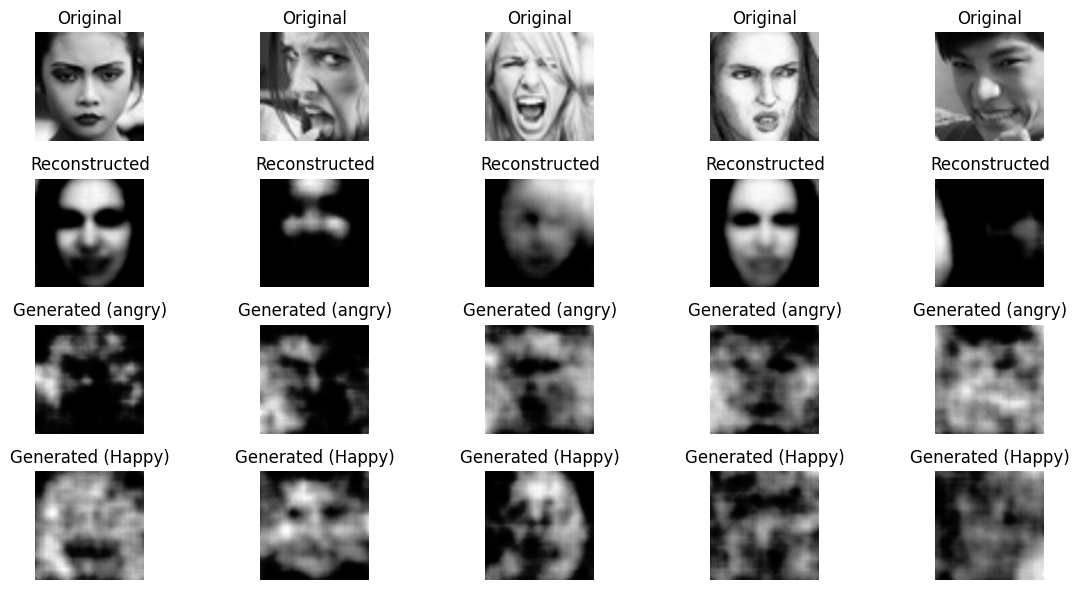

Epoch 16/30 (β=0.0500): 100%|██████████| 294/294 [01:57<00:00,  2.49it/s, Loss=1.69e+4, Recon=1.69e+4, KL=245, β=0.05]


Epoch 16, Avg Train Loss: 16816.9122, β: 0.0500
Epoch: 16, Average Test Loss: 16977.3977


Epoch 17/30 (β=0.0533): 100%|██████████| 294/294 [01:57<00:00,  2.49it/s, Loss=1.66e+4, Recon=1.66e+4, KL=250, β=0.0533]


Epoch 17, Avg Train Loss: 16804.0645, β: 0.0533
Epoch: 17, Average Test Loss: 16975.3105


Epoch 18/30 (β=0.0567): 100%|██████████| 294/294 [01:58<00:00,  2.49it/s, Loss=1.7e+4, Recon=1.7e+4, KL=236, β=0.0567]


Epoch 18, Avg Train Loss: 16789.4345, β: 0.0567
Epoch: 18, Average Test Loss: 16966.1619


Epoch 19/30 (β=0.0600): 100%|██████████| 294/294 [01:57<00:00,  2.49it/s, Loss=1.69e+4, Recon=1.69e+4, KL=223, β=0.06]


Epoch 19, Avg Train Loss: 16780.9263, β: 0.0600
Epoch: 19, Average Test Loss: 16964.0184


Epoch 20/30 (β=0.0633): 100%|██████████| 294/294 [01:58<00:00,  2.49it/s, Loss=1.7e+4, Recon=1.7e+4, KL=234, β=0.0633]


Epoch 20, Avg Train Loss: 16773.9888, β: 0.0633
Epoch: 20, Average Test Loss: 16969.0392


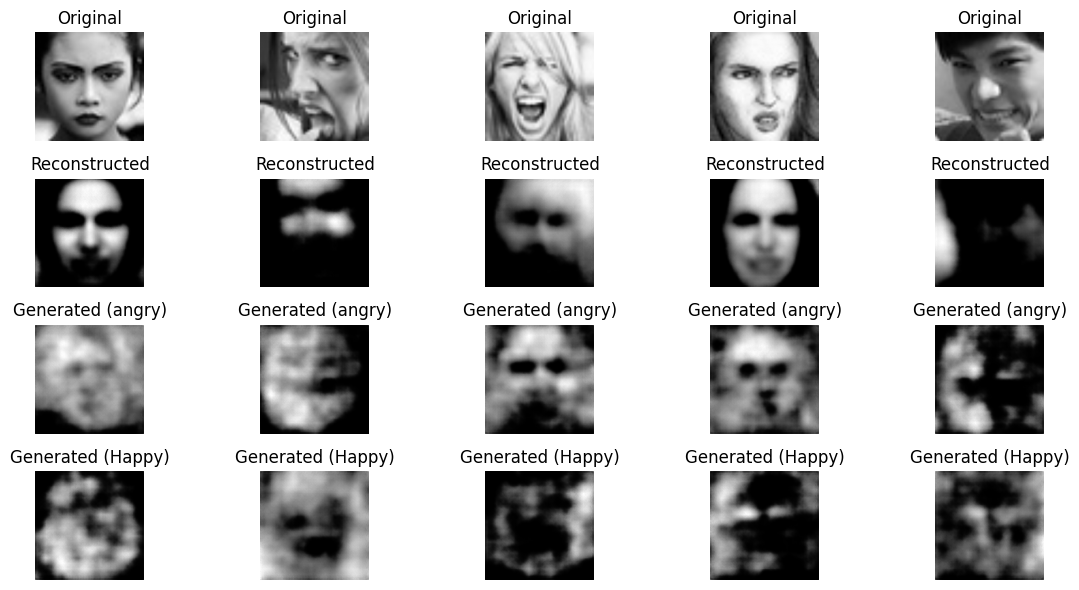

Epoch 21/30 (β=0.0667): 100%|██████████| 294/294 [01:58<00:00,  2.47it/s, Loss=1.67e+4, Recon=1.67e+4, KL=231, β=0.0667]


Epoch 21, Avg Train Loss: 16763.9208, β: 0.0667
Epoch: 21, Average Test Loss: 16953.5484


Epoch 22/30 (β=0.0700): 100%|██████████| 294/294 [01:58<00:00,  2.48it/s, Loss=1.73e+4, Recon=1.73e+4, KL=174, β=0.07]


Epoch 22, Avg Train Loss: 16753.8524, β: 0.0700
Epoch: 22, Average Test Loss: 16962.8178


Epoch 23/30 (β=0.0733): 100%|██████████| 294/294 [01:58<00:00,  2.48it/s, Loss=1.68e+4, Recon=1.68e+4, KL=251, β=0.0733]


Epoch 23, Avg Train Loss: 16746.8663, β: 0.0733
Epoch: 23, Average Test Loss: 16948.8698


Epoch 24/30 (β=0.0767): 100%|██████████| 294/294 [01:58<00:00,  2.47it/s, Loss=1.68e+4, Recon=1.68e+4, KL=189, β=0.0767]


Epoch 24, Avg Train Loss: 16739.4109, β: 0.0767
Epoch: 24, Average Test Loss: 16947.4250


Epoch 25/30 (β=0.0800): 100%|██████████| 294/294 [01:58<00:00,  2.48it/s, Loss=1.69e+4, Recon=1.69e+4, KL=244, β=0.08]


Epoch 25, Avg Train Loss: 16730.8703, β: 0.0800
Epoch: 25, Average Test Loss: 16942.7996


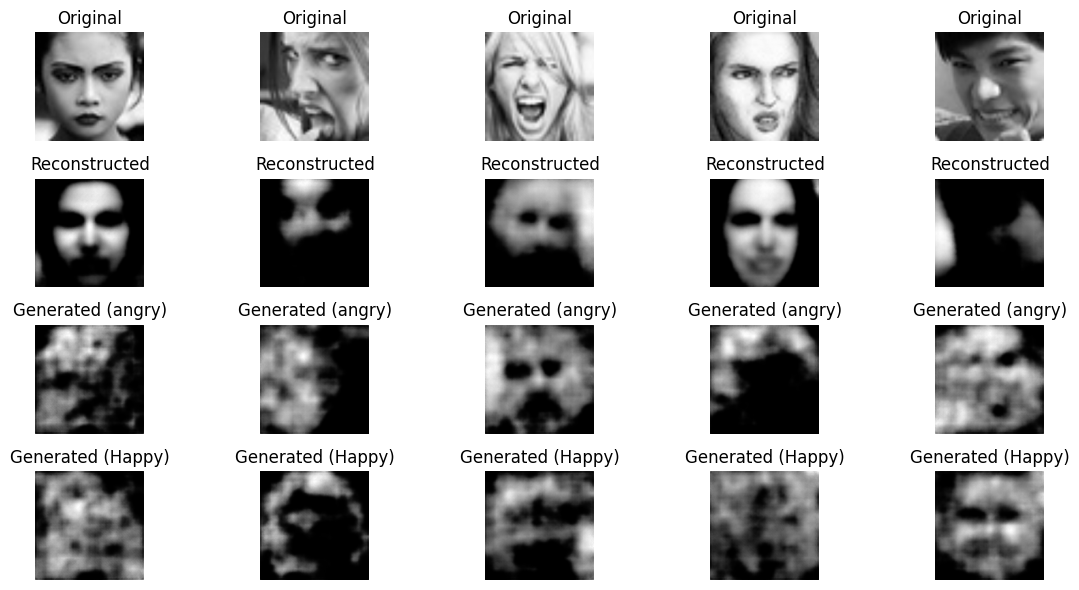

Epoch 26/30 (β=0.0833): 100%|██████████| 294/294 [01:58<00:00,  2.47it/s, Loss=1.66e+4, Recon=1.65e+4, KL=220, β=0.0833]


Epoch 26, Avg Train Loss: 16724.7448, β: 0.0833
Epoch: 26, Average Test Loss: 16927.7475


Epoch 27/30 (β=0.0867): 100%|██████████| 294/294 [01:59<00:00,  2.47it/s, Loss=1.68e+4, Recon=1.68e+4, KL=221, β=0.0867]


Epoch 27, Avg Train Loss: 16720.3078, β: 0.0867
Epoch: 27, Average Test Loss: 16930.2989


Epoch 28/30 (β=0.0900): 100%|██████████| 294/294 [01:58<00:00,  2.47it/s, Loss=1.68e+4, Recon=1.68e+4, KL=195, β=0.09]


Epoch 28, Avg Train Loss: 16714.6196, β: 0.0900
Epoch: 28, Average Test Loss: 16926.7156


Epoch 29/30 (β=0.0933): 100%|██████████| 294/294 [02:00<00:00,  2.44it/s, Loss=1.68e+4, Recon=1.68e+4, KL=195, β=0.0933]


Epoch 29, Avg Train Loss: 16709.5005, β: 0.0933
Epoch: 29, Average Test Loss: 16929.7644


Epoch 30/30 (β=0.0967): 100%|██████████| 294/294 [01:59<00:00,  2.46it/s, Loss=1.68e+4, Recon=1.68e+4, KL=177, β=0.0967]


Epoch 30, Avg Train Loss: 16704.0674, β: 0.0967
Epoch: 30, Average Test Loss: 16924.3616


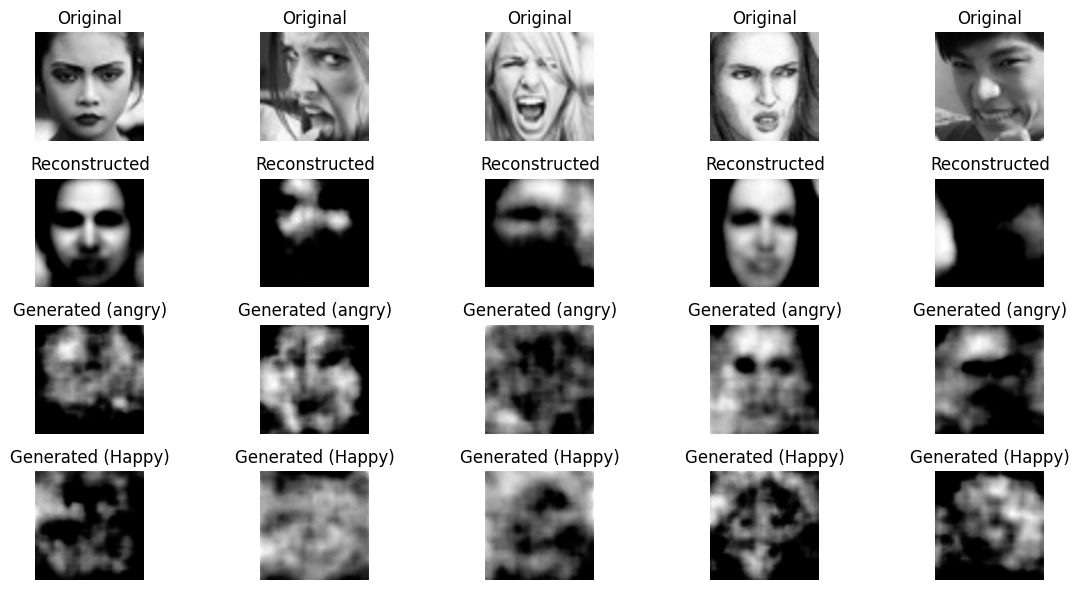

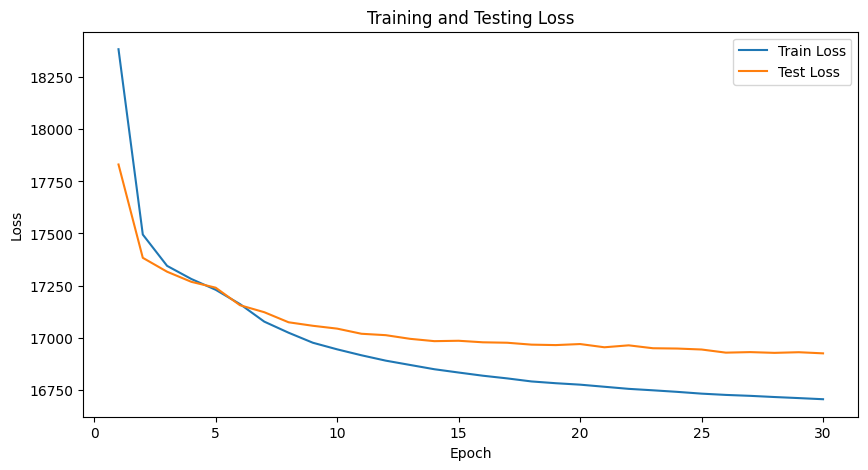

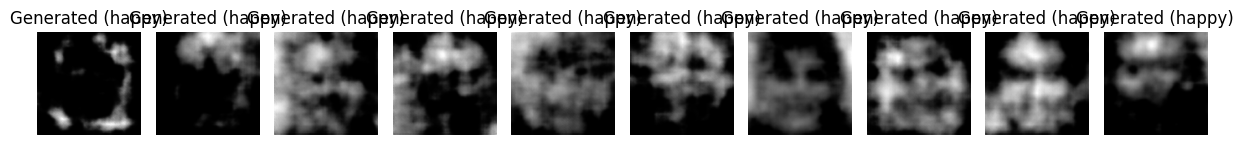

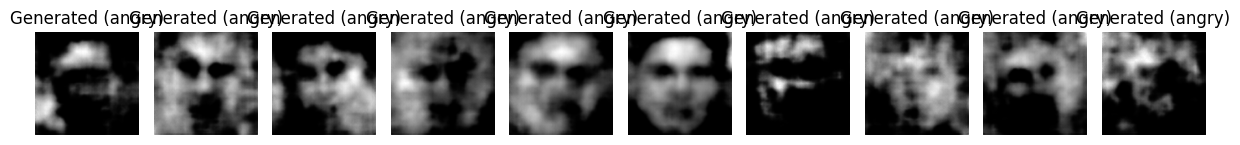

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
import time
from google.colab import runtime

# Your training code here
print("Training finished!")

runtime.unassign()

Training finished!


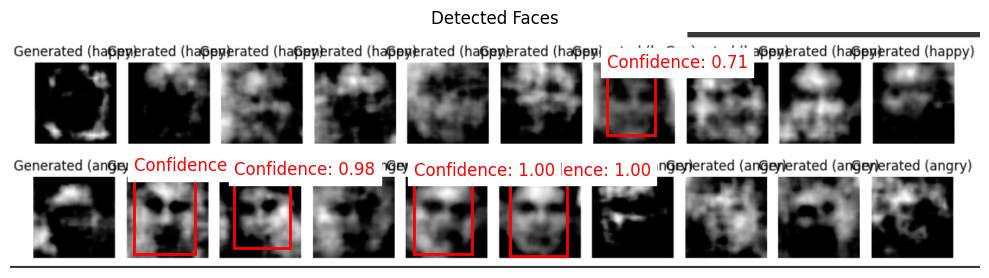

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

# Load an image containing faces
img = Image.open('sample.png')

if img.mode == 'RGBA':
    img = img.convert('RGB')

# Detect faces in the image
boxes, probs = mtcnn.detect(img)

# Convert image for plotting
img_array = np.array(img)

# Plot the original image with face detections
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
ax = plt.gca()

# If faces are detected, extract embeddings and draw boxes
if boxes is not None:
    aligned = mtcnn(img)
    embeddings = resnet(aligned).detach()

    # Draw boxes for each detected face
    for box, prob in zip(boxes, probs):
        # Extract coordinates (x1, y1, x2, y2)
        x1, y1, x2, y2 = box

        # Create rectangle patch
        rect = Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add confidence score text
        plt.text(x1, y1-10, f"Confidence: {prob:.2f}",
                 color='red', fontsize=12, backgroundcolor='white')

plt.title('Detected Faces')
plt.axis('off')
plt.tight_layout()
plt.show()

array([0.9870051145553589, 0.9999264478683472, 0.9962838292121887,
       0.9827365875244141, 0.7109197378158569], dtype=object)

In [ ]:
def face_detection_loss(generated_images, face_detector):
    """
    Calculate a loss based on face detection confidence for generated images
    Returns:
    - loss value (lower if faces are detected with high confidence)
    - detection confidence scores for logging
    """
    # Convert images to format expected by MTCNN
    # MTCNN expects images in [0, 1] range with 3 channels
    images_for_detection = []
    for img in generated_images:
        # If grayscale (1 channel), convert to 3 channels
        if img.size(0) == 1:
            img_3ch = img.repeat(3, 1, 1)
        else:
            img_3ch = img

        # Ensure values are in [0, 1]
        if img_3ch.min() < 0:
            img_3ch = (img_3ch + 1) / 2  # Convert from [-1, 1] to [0, 1]

        images_for_detection.append(img_3ch)

    # Stack images for batch processing
    batch_images = torch.stack(images_for_detection)

    # Detect faces and get confidence scores
    with torch.no_grad():  # Don't track gradients for the detector
        try:
            # Get bounding boxes and probabilities
            boxes, probs = face_detector.detect(batch_images, landmarks=False)

            # Calculate loss based on detection confidence
            loss = 0
            confidences = []

            for i, (box, prob) in enumerate(zip(boxes, probs)):
                if box is None or len(box) == 0:
                    # No face detected, apply maximum penalty
                    loss += 1.0
                    confidences.append(0.0)
                else:
                    # Use 1 - max_confidence as the loss (lower loss for higher confidence)
                    max_confidence = prob.max().item()
                    loss += (1.0 - max_confidence)
                    confidences.append(max_confidence)

            # Average loss across the batch
            loss = loss / len(batch_images)

        except Exception as e:
            # Handle potential errors in face detection
            print(f"Face detection error: {e}")
            loss = 1.0  # Maximum penalty
            confidences = [0.0] * len(batch_images)

    return loss, confidences